# Calibration notebook

About this notebook, we've divided it into the 4 following parts:

1. **Predictions loading**: We load a CSV file with the predictions concerning the model to evaluate.
2. **Evaluations loading**: We load a CSV file with the evaluations concerning the model to evaluate.
3. **Calibrator fit**: After specifying the target measure of interest (e.g., f1-score, accuracy), we fit some calibration models to the transformed predictions using the aforementioned predictions. This introduces some limitations in terms of the granularity of the metrics -- are we fitting it into a discrete/categorical or continuous variable?
5. **Dump calibrated predictions** and **model**: After fitting the model we store the model checkpoint as well as its predictions in the specified folders.


**Note**: We assume that all of these files will have a set of index columns through which we can jointly align them.


In [1]:
ROOT_DIR = "../outputs/results/mocha/narrativeqa/dev4"
!mkdir -p {ROOT_DIR}

# TODO - Come up with some uuid (model_name + dataset + split)
PREDS_FILEPATH = f"{ROOT_DIR}/preds/dev4-uqa-t5-small_preds.csv.gz"
EVALS_FILEPATH = f"{ROOT_DIR}/evals/dev4-uqa-t5-small_evals.csv.gz"

# TODO - MODEL UUID
ROOT_DIR_CALIB = f"{ROOT_DIR}/calib"
!mkdir -p {ROOT_DIR_CALIB}

CALIB_MODEL_METADATA = f"{ROOT_DIR_CALIB}/models/dev4-uqa-t5-small-lr-uuid.metadata"
CALIB_MODEL_FILEPATH = f"{ROOT_DIR_CALIB}/models/dev4-uqa-t5-small-lr-uuid.joblib"
CALIB_PREDS_FILEPATH = f"{ROOT_DIR_CALIB}/preds/dev4-uqa-t5-small-lr-uuid.csv.gz"

# Arguments used to read the files from disk
csv_kwargs = {
   "compression": "gzip"
}

ID_COLS = ["example_id", "answer_id"]

# The features used in the calibration method
CALIBRATION_FEATURES = ["score_proba"]

# The name of the feature in the target that we're trying to calibrate towards
UNCALIBRATED_SCORE_COL = "score_proba"

# The metric we're calibrating w.r.t.
CALIBRATION_TARGET = "exact_match"

In [2]:
import pandas as pd
import numpy as np

## Predictions & Evaluations loading

In [3]:
preds = pd.read_csv(PREDS_FILEPATH, **csv_kwargs).set_index(ID_COLS)
evals = pd.read_csv(EVALS_FILEPATH, **csv_kwargs).set_index(ID_COLS)

# Define the training data for the calibrator
X = preds[CALIBRATION_FEATURES]

# Uncalibrated and calibrated values
y_original = preds[UNCALIBRATED_SCORE_COL]
y_true = evals[CALIBRATION_TARGET]

## Calibration methods

In this section, we're trying out different calibration prototypes based on [this tutorial](https://davidrosenberg.github.io/ttml2021fall/calibration/2.calibration.pdf). It's main purpose is to give a better understanding of the inner details and strengths of each classical model.

In this tutorial, the authors explore 4 different calibration methods. In the tutorial the authors assume a binary calibration setting, where the goal is to find the function that better fits the relationship between the scores and the true probabilities: 
- 1. Platt scaling:  
- 2. Beta calibration: 
- 3. Isotonic regression: 
- 4. SplineCalib: 

In [4]:
try:
    import ml_insights as mli
    import matplotlib.pyplot as plt
    %matplotlib inline

    from sklearn.ensemble import RandomForestClassifier
    from sklearn.isotonic import IsotonicRegression
    from sklearn.linear_model import LogisticRegression
    from sklearn.calibration import calibration_curve
    from betacal import BetaCalibration
    print(mli.__version__)
except:
    !pip install ml_insights
    !pip install betacal


# TODO - Place in calibration_evals.py
from sklearn.metrics import log_loss, brier_score_loss
from scipy.stats import spearmanr, pearsonr, kendalltau

CALIBRATION_MEASURES = {
    # Discrete measures of calibration
    # - Binary metric
    "brier_score": brier_score_loss,
    # - Categorical metric
    "log_loss": log_loss,
    
    # Mixed
    "pearson": pearsonr,
    "spearman": spearmanr,
    "kendall_tau": kendalltau,
}


def evaluate_calibration(y_true, y_pred, ndigits: int=4, metrics: dict=None):
    """Computes measures of calibration for provided set of predictions
    
    # Notes
    -------
    Calibration measures:
    ``logloss``: assesses the combination of discrimination and calibration.
    ``log_loss`` is difficult to interpret on its own, generally used 
    comparatively. Penalizes the ratios more heavily (e.g., 0.001 vs 0.0001
    rather than 0.2 vs 0.3). 

    ``brier_score``: Brier score is a fancy name for the mean squared error
    between the predicted probabilities and the true (0/1) answer. If I predict
    0.7 on a case that was true (1), my error for that case is $(1-0.7)^2$.
    Focuses more on the absolute differences of larger values (0.3 vs 0.7,
    rather than 0.001 and 0.00001).

    """
    metrics = metrics if metrics else CALIBRATION_MEASURES
    
    results = {}
    for score_name, score_fn in metrics.items(): 
        results[score_name] = round(score_fn(y_true, y_pred), ndigits)
    
    return results

1.0.0


About the plot:
- Length of the acceptance intervals gets larger as we have less data points.
- Ideal: have good calibration across all areas -- (awful result is to have good calibration in rare regions).
- If too little data - may consider merging bins. I'm not confident that this will is useful for NLP in practice.

(array([0.01409746, 0.06959336, 0.12540899, 0.17661932, 0.22444736,
        0.27828618, 0.32914342, 0.37373735, 0.42511574, 0.47011375,
        0.51883316, 0.57875258, 0.62302927, 0.67314951, 0.72220071,
        0.77455663, 0.82024397, 0.86971668, 0.90794883, 0.98737943]),
 array([0.02777778, 0.04545455, 0.15384615, 0.4       , 0.33333333,
        0.21428571, 0.33333333, 0.28571429, 0.5       , 0.77777778,
        0.3       , 0.83333333, 0.3       , 0.85714286, 0.66666667,
        0.75      , 0.78571429, 0.8       , 1.        , 0.        ]),
 array([36., 22., 13., 10., 15., 14., 18., 14.,  8.,  9., 10.,  6., 10.,
        21., 24., 20., 14., 10.,  2.,  1.]))

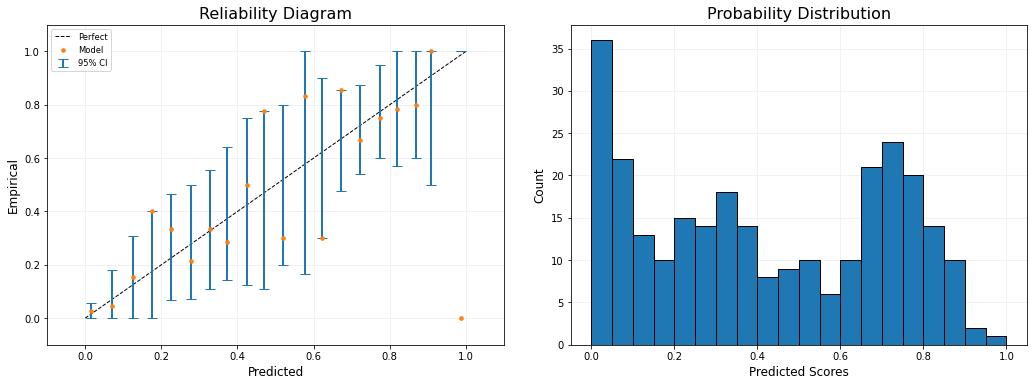

In [5]:
plt.figure(figsize=(15, 6))
rd = mli.plot_reliability_diagram(y_true, y_original, show_histogram=True);
rd['pred_probs'], rd['emp_probs'], rd['bin_counts']

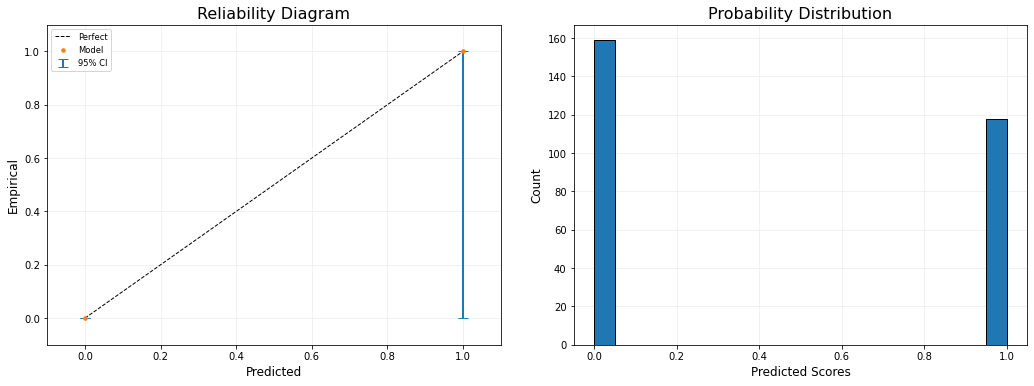

In [6]:
plt.figure(figsize=(15, 6)); mli.plot_reliability_diagram(y_true, y_true, show_histogram=True);

### Logistic Regression (or Platt Scaling)

**Main idea**: View each 0/1 label as noisy version of the actual 0/1 labels. Replace each instance with label 1 with its probabilistic soft label. 

It assumes that there is a logistic relationship between the scores $z$ and the true probability $p$, described by the logistic function $\sigma(z) = \frac{1}{1+e^{-(az+b)}}$. 


**Pros**:
- Preserves ranking (yields a smooth and strictly increasing calibration) (?? provided we only use information about the true scores).

- Useful for avoiding overfitting to rare classes.
- Usually the fewer the #params the less data required.

**Cons**:
- Assumes $z \in [0, 1]$
- Constrained to the set of sigmoidal functions.
- Platt scaling messes up perfectly calibrated models.


#### Questions
- [x] Would it work with continuous targets? ~~Yes!~~ Does not work in the `sklearn` version. 
- [ ] How can I use CS274A to interpret this?

In [7]:
model_classpath = LogisticRegression
model_hyperparams = {
    "fit_intercept": True,
    "random_state": 42,
}

Params: [[3.52537443]] Intercept: [-1.85176012]


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


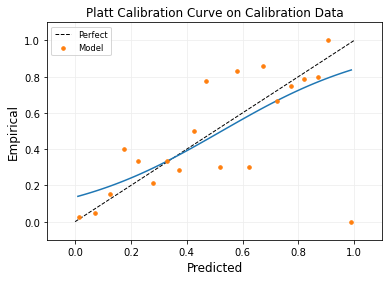

In [8]:
model = model_classpath(**model_hyperparams)
model.fit(X, y_true)
print("Params:", model.coef_, "Intercept:", model.intercept_)

y_preds = model.predict_proba(X)[:,1]

# Evaluation
mli.plot_reliability_diagram(y_true, y_original, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, model.predict_proba(tvec.reshape(-1,1))[:,1]);
plt.title('Platt Calibration Curve on Calibration Data');

### Isotonic Regression


- Fits a piecewise constant, monotonically increasing, function to map the scores to probabilities.
- Uses the PAV (Pool Adjacent Violators, also called PAVA) algorithm.

**Pros**:
- Tends to be better than Platt scaling with enough data
- Does not assume a particular parametric form.
- Seems to work for $y \in \mathrm{R}$

**Cons**:
- Tends to overfit: ("choppy" with unrealistic jumps)
- Some bins tend to have few to no points after calibration due to the vertical "steps" in the function.
- Isotonic regression is relatively "data-hungry"


**References**:
- Zadrozny, B., & Elkan, C. (2002). Transforming classifier scores into accurate multiclass probability estimates. KDD (pp.694–699

#### Questions
- [ ] How does it work?

In [9]:
model_classpath = IsotonicRegression
model_hyperparams = {
    "out_of_bounds": 'clip',
    "y_min": 0, 
    "y_max": 1,
}

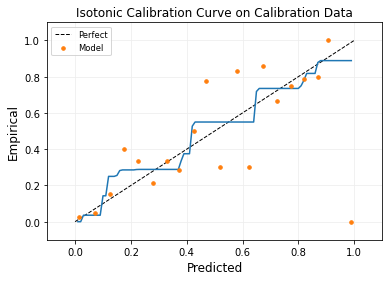

In [10]:
model = model_classpath(**model_hyperparams)
model.fit(X, y_true)

y_preds = model.predict(X)

# Evaluation
mli.plot_reliability_diagram(y_true, y_original, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, model.predict(tvec.reshape(-1,1)));
plt.title('Isotonic Calibration Curve on Calibration Data');

### Beta calibration

_A well-founded and easily implemented improvement on logistic calibration for binary classifiers._
$p = \frac{1}{1+e^c}$


- Similar to Platt scaling with a couple of important improvements
- Is a 3-parameter family of curves rather than 2-parameter
- Family of curves includes the line 

(so it won't mess it up if it's already calibrated)

**References**:
- Kull, M., Filho, T.S. & Flach, P.. (2017). Beta calibration: a well-founded and easily implemented improvement on logistic calibration for binary classifiers. Proceedings of the 20th International Conference on Artificial Intelligence and Statistics, in PMLR 54:623-631


#### Questions
- [ ] How does it work?

In [11]:
model_classpath = BetaCalibration
model_hyperparams = { "parameters": "abm" }

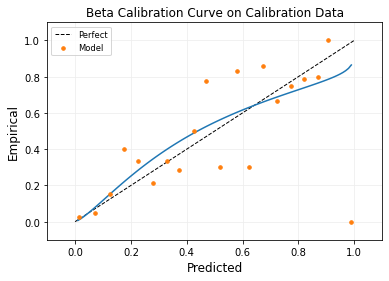

In [12]:
model = model_classpath(**model_hyperparams)
model.fit(X, y_true)

y_preds = model.predict(X)

# Evaluation
mli.plot_reliability_diagram(y_true, y_original, error_bars=False);
tvec = np.linspace(.01, .99, 99)
plt.plot(tvec, model.predict(tvec.reshape(-1,1)));
plt.title('Beta Calibration Curve on Calibration Data');

## Store model and calibrated predictions

In [13]:
import joblib
import yaml

In [14]:
# We re-use the same structure as the preds we've loaded initially
# write them into a calibrated predictions file.
preds[UNCALIBRATED_SCORE_COL] = y_preds
preds.to_csv(CALIB_PREDS_FILEPATH, **csv_kwargs)

# Sanity check
pd.read_csv(CALIB_PREDS_FILEPATH, **csv_kwargs)

,example_id,answer_id,score_proba
0,f485d3509a0606a7b570cc5f2edbd083,e2fd235719de9140057fdb4e61e930e9,0.380354
1,921d4e8c8c14e3b385bb80546b792154,b1a98f8723f1df6c2a71c2ce80f8af52,0.721753
2,6a1962b5dbe9a81cb75bb07dbf5669ef,e9ae37f4295ebdd6784bee441be81df4,0.748860
3,1a1d261030142098c1bfeb7cb89d796e,5ef799ab36e56957ee6cb47ed2b7d47b,0.679293
4,675936324cb453372def083ee268e7ca,f8f5f8da83093b4a291abc0328431a00,0.509115
...,...,...,...
272,159e9b469758f1cc6eeac013bd18a9db,3541ca5d5f8fc10a7954020ff6259a40,0.068703
273,f60bdcc6403153595ef91a23c2610ac0,57969ef43933681ffc5b151cb637531c,0.653283
274,bb367ed82eecadcc793ad672cf75bc21,764587468753def4644d0a675f5d29bc,0.675711
275,92cf35db62a8b8b885ae6bd88b74796e,83eeb53928af196b2521ec80c13d3594,0.368847


In [15]:
joblib.dump(model, CALIB_MODEL_FILEPATH)

with open(CALIB_MODEL_METADATA + ".metadata", "w") as metadata_file:
    yaml.dump({
        "model_classpath": f"{model_classpath.__module__}.{model_classpath.__qualname__}",
        "model_hyperparams": model_hyperparams,
    }, metadata_file)
    
!ls -altrh {ROOT_DIR_CALIB}/models

total 16K
drwxrwxr-x 2 kat kat 4.0K Feb 18 20:46 .
drwxrwxr-x 4 kat kat 4.0K Feb 18 20:49 ..
-rw-rw-r-- 1 kat kat   78 Feb 18 20:54 dev4-uqa-t5-small-lr-uuid.metadata.metadata
-rw-rw-r-- 1 kat kat  985 Feb 18 20:54 dev4-uqa-t5-small-lr-uuid.joblib
